## Recreating the Master Unit List

#### setup/imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import pudl
import pudl.constants as pc
import pudl.extract.ferc1
import sqlalchemy as sa
import logging
import sys
import copy
import pathlib
from copy import deepcopy

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [4]:
import sys
sys.path.append("../") # go to parent dir
from plant_part_agg_eia import *
from plant_parts import plant_parts
pd.options.display.max_columns = None

In [5]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

#### defining a table grabbing objectDEBUG

In [6]:
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings["pudl_db"])
pt = pudl.output.pudltabl.get_table_meta(pudl_engine)
start_date=None
end_date=None
freq='AS'

In [7]:
pudl_out = pudl.output.pudltabl.PudlTabl(pudl_engine,freq='AS',rolling=True)

In [8]:
table_compiler = CompileTables(pudl_engine, freq='AS', rolling=True)

In [9]:
self = CompilePlantParts(table_compiler, plant_parts, clobber=True)

In [10]:
%%time
plant_parts_df = self.generate_master_unit_list()

beginning the aggregation for generation_eia923
grabbing generation_eia923 from the sqlite db
Converting the dtypes of: generation_eia923
beginning the aggregation for generators_eia860
grabbing generators_eia860 from the sqlite db
Converting the dtypes of: generators_eia860
beginning the aggregation for mcoe
grabbing mcoe from the output object
filling in fuel cost NaNs with rolling averages
Converting the dtypes of: mcoe
grabbing ownership_eia860 from the sqlite db
Converting the dtypes of: ownership_eia860
grabbing boiler_generator_assn_eia860 from the sqlite db
Converting the dtypes of: boiler_generator_assn_eia860
grabbing generators_entity_eia from the sqlite db
Converting the dtypes of: generators_entity_eia
begin aggregation for: plant_prime_fuel
begin aggregation for: plant_technology
begin aggregation for: plant_prime_mover
begin aggregation for: plant_gen
begin aggregation for: plant_unit
begin aggregation for: plant
grabbing utilities_eia from the sqlite db
Converting the d

In [11]:
self.test_run_aggregations()

Begining tests for plant:
  Results for total_fuel_cost: [True, False]
  Results for net_generation_mwh: [True, False]
  Results for capacity_mw: [True, False]
  Results for total_mmbtu: [True, False]
Begining tests for plant_unit:
  Results for capacity_mw: [True, False]
  Results for net_generation_mwh: [True, False]
  Results for total_fuel_cost: [True, False]
  Results for total_mmbtu: [True, False]
Begining tests for plant_prime_mover:
  Results for capacity_mw: [True, False]
  Results for net_generation_mwh: [True, False]
  Results for total_fuel_cost: [True, False]
  Results for total_mmbtu: [True, False]
Begining tests for plant_technology:
  Results for capacity_mw: [True, False]
  Results for net_generation_mwh: [True, False]
  Results for total_fuel_cost: [True, False]
  Results for total_mmbtu: [True, False]
Begining tests for plant_prime_fuel:
  Results for capacity_mw: [True, False]
  Results for net_generation_mwh: [True, False]
  Results for total_fuel_cost: [True, Fals

In [12]:
gb_df = (self.plant_gen_df[self.plant_gen_df['ownership'] == 'owned']
         .groupby(by=['plant_id_eia','report_date'])
         .agg({'generator_id': 'nunique',
               'utility_id_eia':'nunique',})
    .reset_index()
)
gb_df.mean()

plant_id_eia      35719.577866
generator_id          2.889937
utility_id_eia        1.110957
dtype: float64

In [13]:
logger.info(len(plant_parts_df[(plant_parts_df.ownership == 'owned')
                               & plant_parts_df.true_gran]))
logger.info(len(plant_parts_df[(plant_parts_df.ownership == 'total')
                               & plant_parts_df.true_gran]))
logger.info(len(plant_parts_df[plant_parts_df.true_gran]))

328855
48380
377235


### Investigate Full Cost Nulls

In [14]:
%%time
table_compiler_no_freq = CompileTables(pudl_engine)
# this cell takes a long time.. fyi
frc = table_compiler_no_freq.grab_the_table('fuel_receipts_costs_eia923')
mcoe = table_compiler.grab_the_table('mcoe')

grabbing fuel_receipts_costs_eia923 from the sqlite db
Converting the dtypes of: fuel_receipts_costs_eia923
CPU times: user 8.67 s, sys: 460 ms, total: 9.13 s
Wall time: 9.2 s


In [15]:
def count_the_unique_plants(df, count_col):
    df = df.astype({'report_date':'datetime64[ns]'})
    df = df.assign(report_year=df.report_date.dt.year)
    return (len(df[(df[count_col].notnull())
                   & (df[count_col] != 0)].
              drop_duplicates(subset=['plant_id_eia','report_year'])))

In [16]:
# these values should be more or less the same, assuming that there isn't a ton of lost records
# we should expect that the number of records in the main fuel table to be the most complete
logger.info('Fuel Table:          ' + str(count_the_unique_plants(frc,'fuel_cost_per_mmbtu')))
logger.info('MCOE Table:          ' + str(count_the_unique_plants(mcoe,'fuel_cost_per_mmbtu')))
logger.info('Master Unit List:    ' + str(count_the_unique_plants(plant_parts_df,'fuel_cost_per_mmbtu')))
logger.info('Generators from MUL: ' + str(count_the_unique_plants(plant_parts_df[plant_parts_df['plant_part'] == 'plant_gen'],'fuel_cost_per_mmbtu')))

Fuel Table:          6461
MCOE Table:          6241
Master Unit List:    6222
Generators from MUL: 6222


In [17]:
plant_parts_df.to_csv('master_unit_list.csv')

In [18]:
compiled_plant_parts = {}
compiled_plant_parts_true = {}
true_parts_df = plant_parts_df[plant_parts_df.true_gran]
for part in plant_parts.keys():
    part_df = plant_parts_df[(plant_parts_df['plant_part'] == part)]
    compiled_plant_parts_true[part] = true_parts_df[(true_parts_df['plant_part'] == part)]
    compiled_plant_parts[part] = part_df

In [19]:
def plot_plant_vs_agg(compiled_plant_parts, field, xy_limits, scale):
    """
    Make plots to compare FERC & EIA reported values for Coal & Gas plants.
    
    For each of the fields specified in fields_to_plot, create a pair of plots,
    one for 'gas' and one for 'coal' in the same frame, showing the EIA quantity
    vs. the FERC quantity in a scatter plot.
    """
    for plant_gran, df in compiled_plant_parts.items():
        if plant_gran != 'plant':
            field_plant = field+'_plant'
            field_gran = field+'_'+plant_gran
            try:
                merge_df = compiled_plant_parts['plant'].merge(df, on=['plant_id_eia', 
                                                                       'report_date',
                                                                       'utility_id_eia',
                                                                       'ownership'
                                                                      ], suffixes=('_plant','_' + plant_gran))
                # this is for the try
                merge_df[field_gran]
                #merge_df = merge_df[merge_df['plant_id_eia'] == 3]
                fig, (ax) = plt.subplots(ncols=1, nrows=1, figsize=(5, 5))
                ax.scatter(merge_df[field_plant],
                           merge_df[field_gran],
                           color='black', alpha='0.1', label=field)
                ax.set_ylim(xy_limits[field][0],xy_limits[field][1])
                ax.set_xlim(xy_limits[field][0],xy_limits[field][1])
                ax.set_xscale(scale)
                ax.set_yscale(scale)
                ax.set_ylabel(f'{plant_gran} {field}')
                ax.set_xlabel(f'Plant {field}')
                ax.set_title(f"Plant vs {plant_gran}: {field}")
            except KeyError:
                pass

/Users/christinagosnell/miniconda3/envs/pudl-dev/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


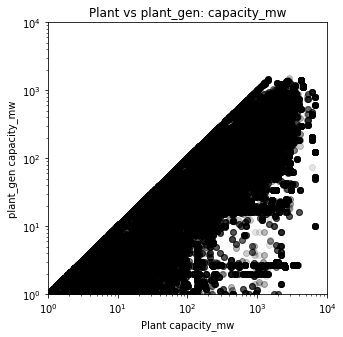

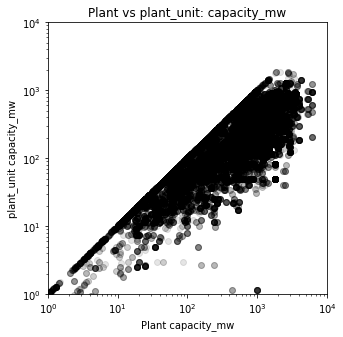

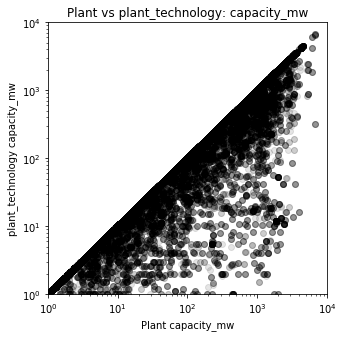

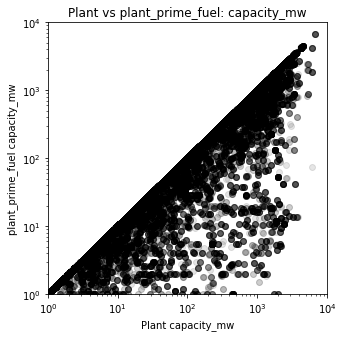

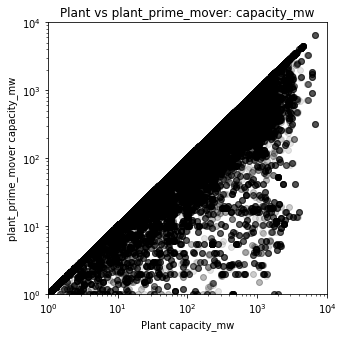

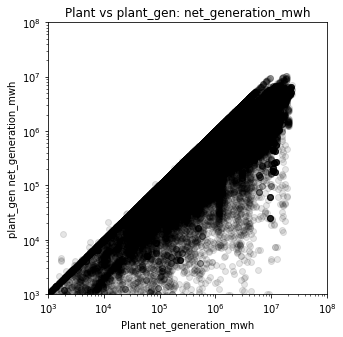

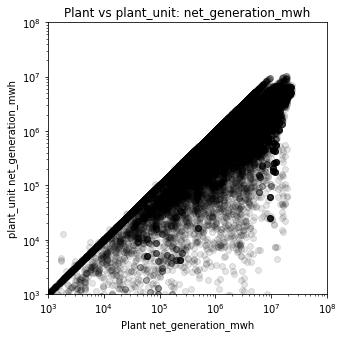

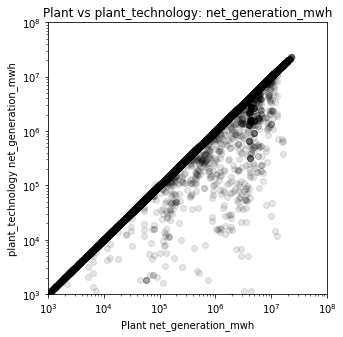

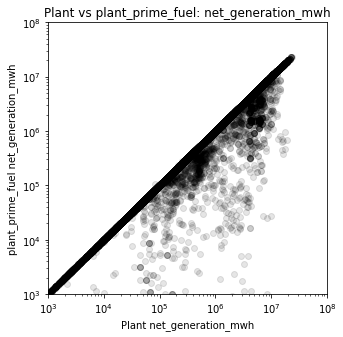

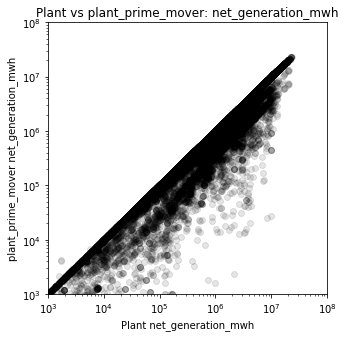

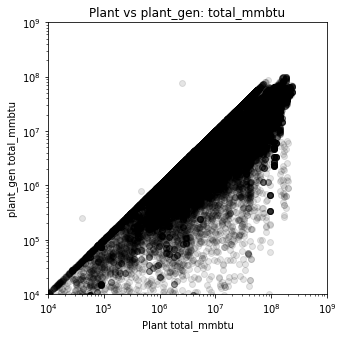

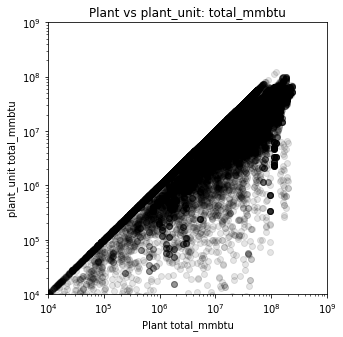

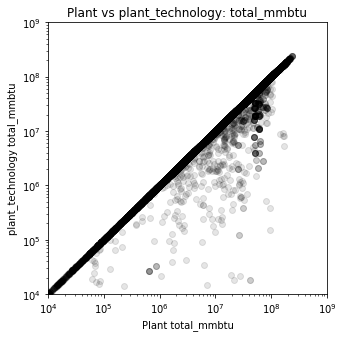

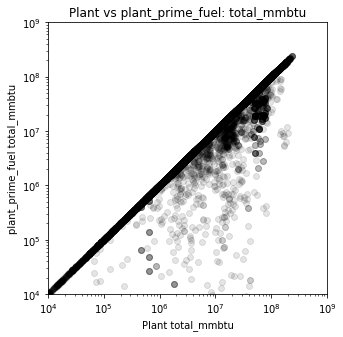

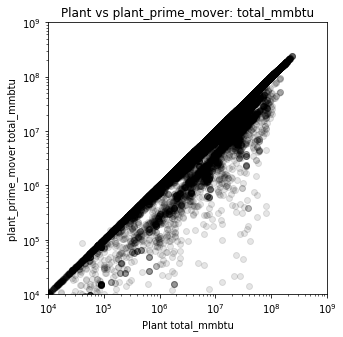

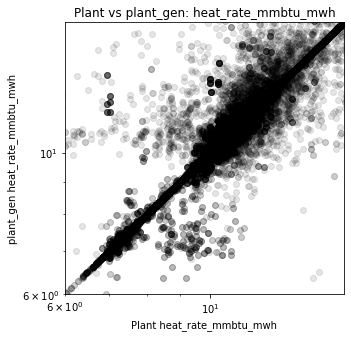

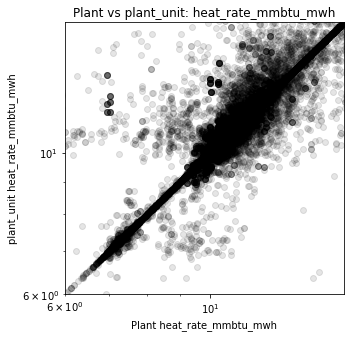

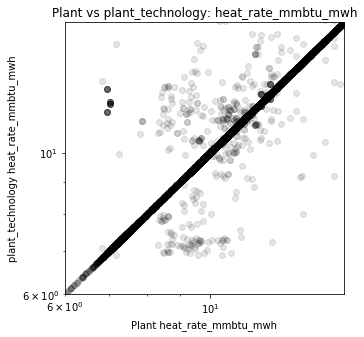

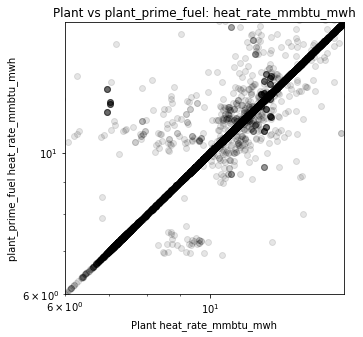

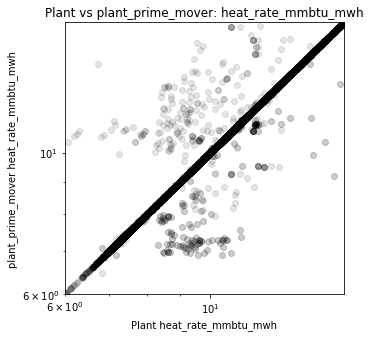

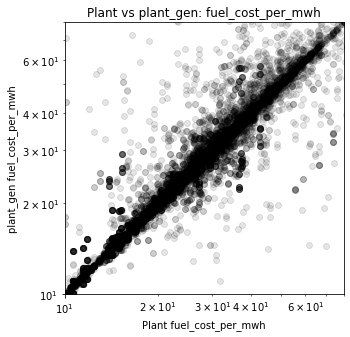

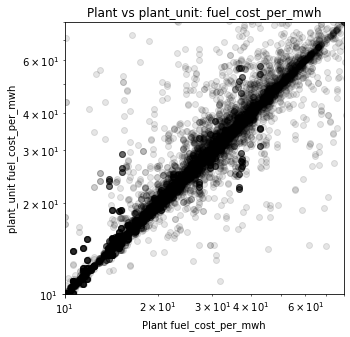

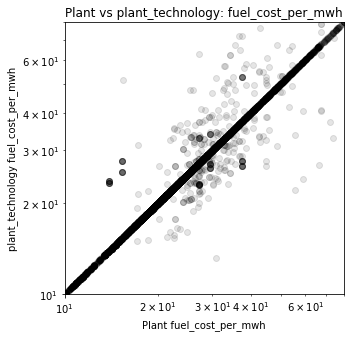

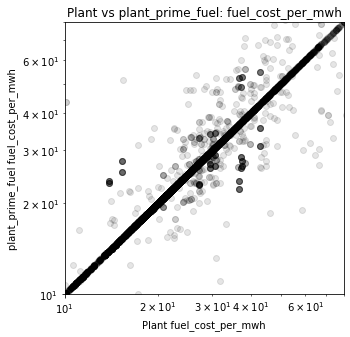

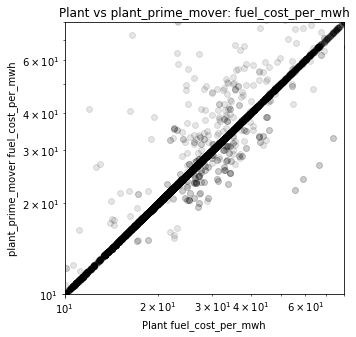

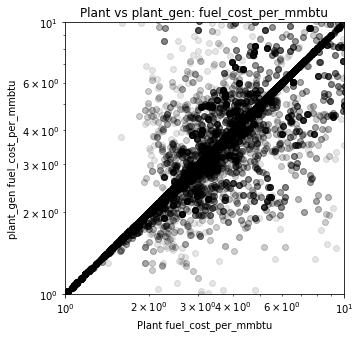

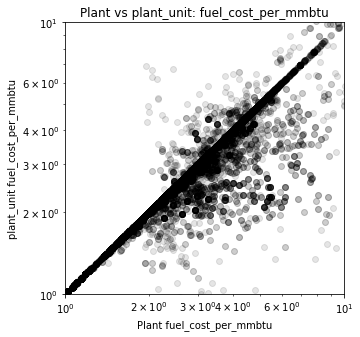

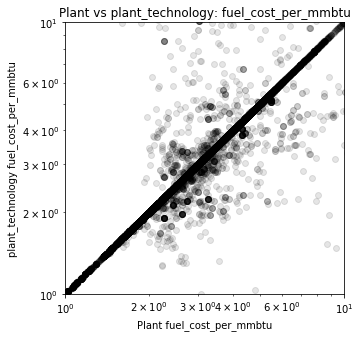

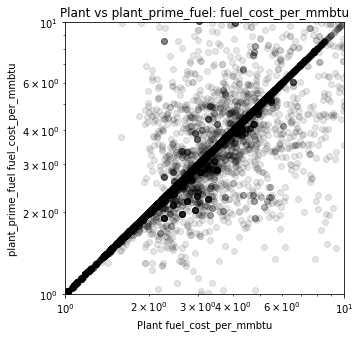

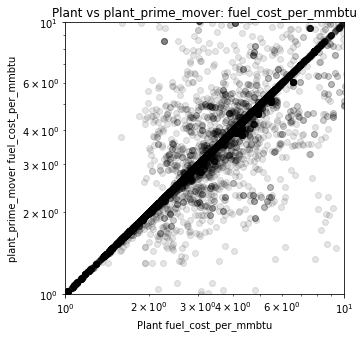

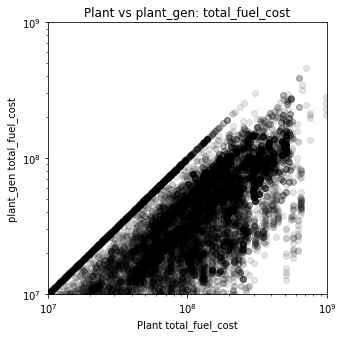

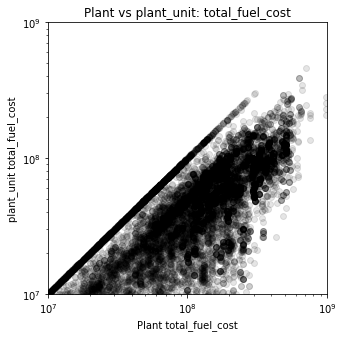

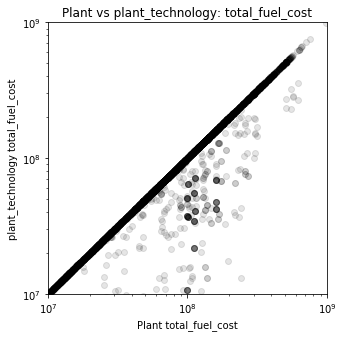

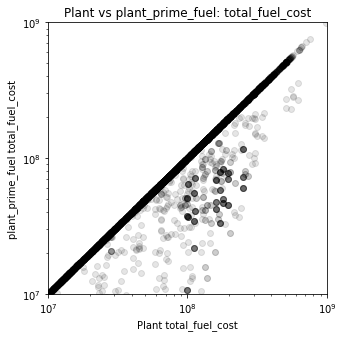

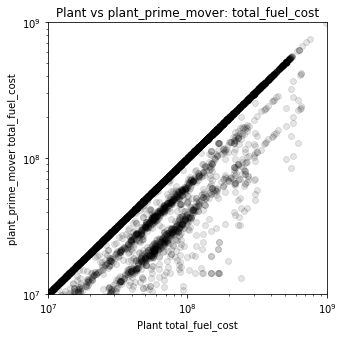

In [20]:
fields_to_plot = [
    # Simple Quantities
    'capacity_mw',
    'net_generation_mwh',
    'total_mmbtu',
    # Derived values
    #'capacity_factor',
    'heat_rate_mmbtu_mwh',
    'fuel_cost_per_mwh',
    'fuel_cost_per_mmbtu',
    'total_fuel_cost'
]

xy_limits = {
    # Simple Quantities
    'capacity_mw': (1e0, 1e4),
    'net_generation_mwh': (1e3,1e8),
    'total_mmbtu': (1e4,1e9),
    # Derived values
    'capacity_factor': (0,1.0),
    'heat_rate_mmbtu_mwh': (6,16),
    'fuel_cost_per_mwh': (10,80),
    'fuel_cost_per_mmbtu': (1e0,1e1),
    'total_fuel_cost': (1e7,1e9)
}

for field in fields_to_plot:
    plot_plant_vs_agg(compiled_plant_parts,field, xy_limits, scale="log")

In [21]:
def plot_gens_vs(compiled_plant_parts,part_name, data_col, weight_col, x_range):
    gen_df = compiled_plant_parts['plant_gen'][compiled_plant_parts['plant_gen'][data_col] != 0]
    part_df = compiled_plant_parts[part_name][compiled_plant_parts[part_name][data_col] != 0]
    if weight_col:
        weights_gen = gen_df[weight_col]
        weights_part = part_df[weight_col]
    else:
        weights_gen = None
        weights_part = None

    plt.hist(gen_df[data_col], 
             weights=weights_gen,
             range=x_range,
             bins=100,
             color="purple", #alpha=test_alpha,
             label="Generators")

    plt.hist(part_df[data_col], 
             weights=weights_part,
             range=x_range,
             bins=100,
             color="black",
             label=f'{part_name}')

    plt.title(f'Gens vs. {part_name}: {data_col}')
    plt.xlabel(data_col)
    plt.ylabel(None)
    plt.legend()
    plt.show()

In [22]:
x_ranges = {
    'capacity_mw' : (0,400),
    'net_generation_mwh': (0, 2500000),
    'fuel_cost_per_mmbtu': (0, 5),
    'fuel_cost_per_mwh': (0, 100),
    'total_fuel_cost': (0,200000000)
}

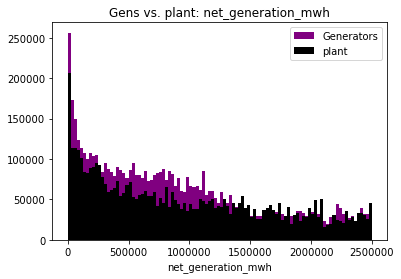

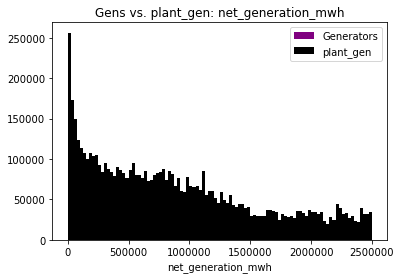

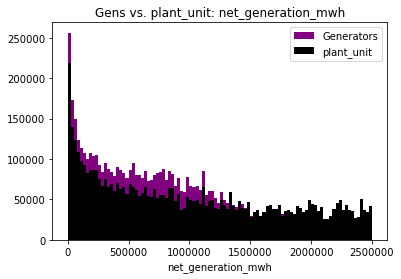

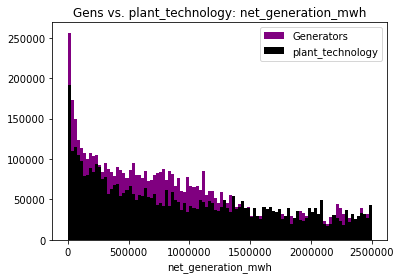

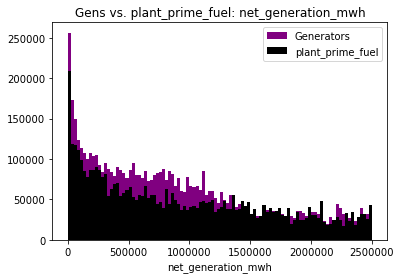

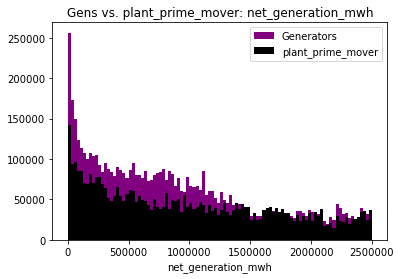

In [23]:
for part_name in compiled_plant_parts.keys():
    data_col =  'net_generation_mwh'
    weight_col = 'capacity_mw'
    plot_gens_vs(compiled_plant_parts,
                 part_name=part_name,
                 data_col=data_col, 
                 weight_col=weight_col,
                 x_range=x_ranges[data_col])

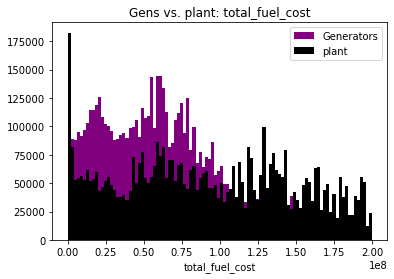

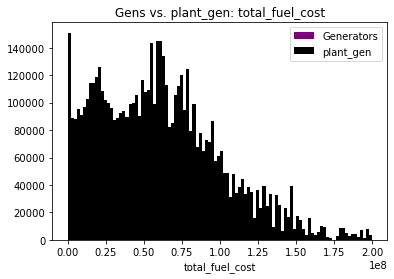

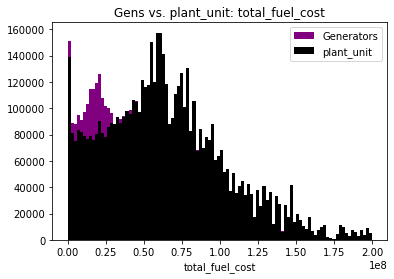

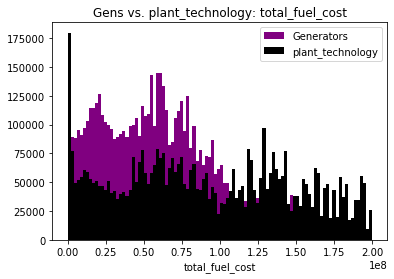

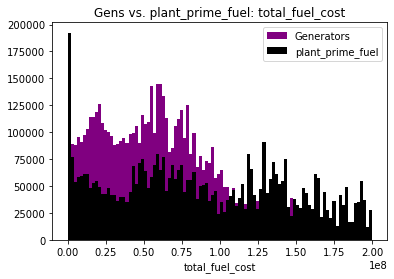

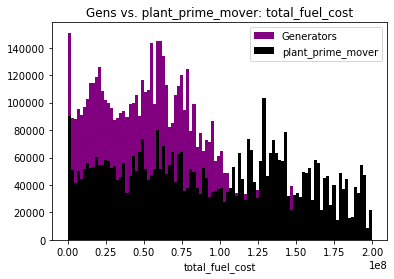

In [24]:
for part_name in compiled_plant_parts.keys():
    data_col =  'total_fuel_cost'
    weight_col = 'capacity_mw'
    plot_gens_vs(compiled_plant_parts,
                 part_name=part_name,
                 data_col=data_col, 
                 weight_col=weight_col,
                 x_range=x_ranges[data_col])

/Users/christinagosnell/miniconda3/envs/pudl-dev/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/christinagosnell/miniconda3/envs/pudl-dev/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


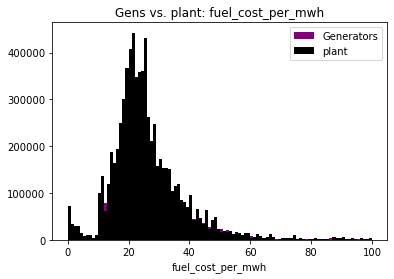

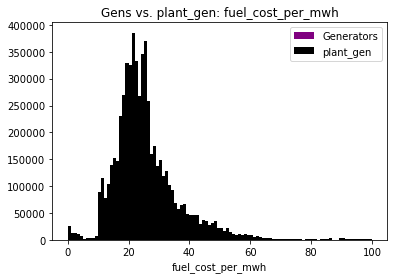

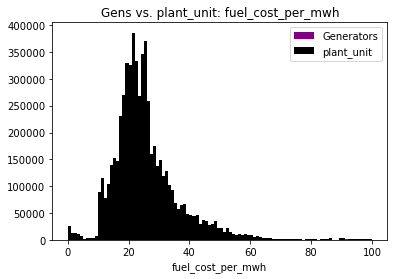

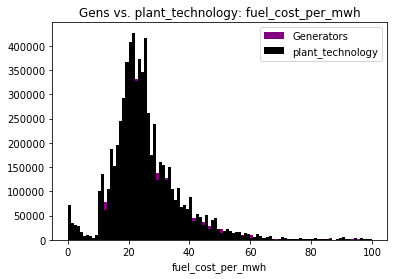

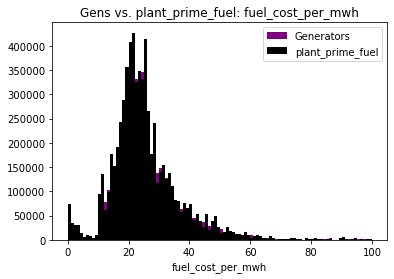

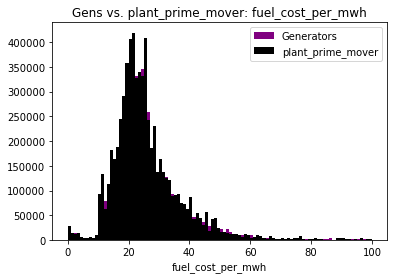

In [25]:
for part_name in compiled_plant_parts.keys():
    data_col =  'fuel_cost_per_mwh'
    weight_col = 'capacity_mw'
    plot_gens_vs(compiled_plant_parts,
                 part_name=part_name,
                 data_col=data_col, 
                 weight_col=weight_col,
                 x_range=x_ranges[data_col])

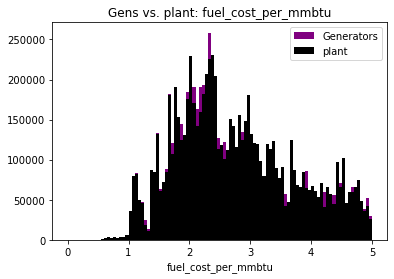

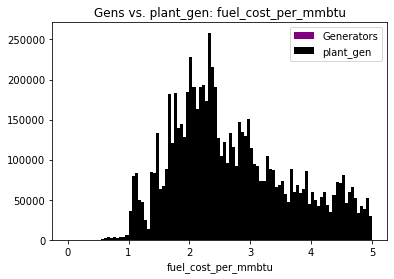

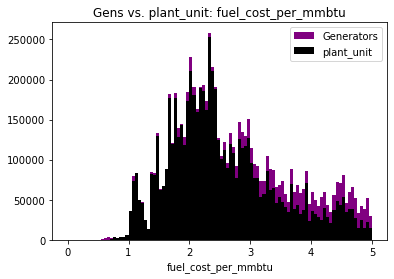

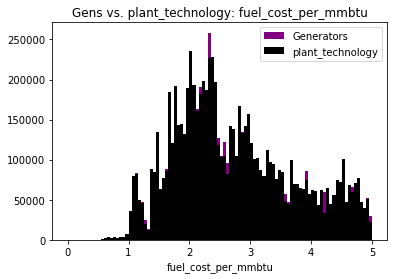

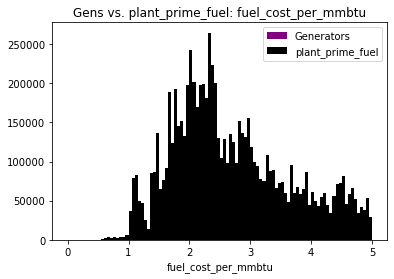

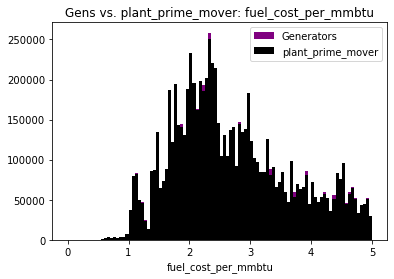

In [26]:
for part_name in compiled_plant_parts.keys():
    data_col =  'fuel_cost_per_mmbtu'
    weight_col = 'capacity_mw'
    plot_gens_vs(compiled_plant_parts,
                 part_name=part_name,
                 data_col=data_col, 
                 weight_col=weight_col,
                 x_range=x_ranges[data_col])

## Playing with the compiled outputs 

In [27]:
null_zeros = {0:np.NaN}
count_df = pd.DataFrame(index=list(compiled_plant_parts['plant'].columns))
for k,cpp_df in compiled_plant_parts.items():
    cpp_df = cpp_df.replace({
        'net_generation_mwh':null_zeros,
        'capacity_factor' : null_zeros,
        'fuel_cost_per_mmbtu': null_zeros,
        'fuel_cost_per_mwh': null_zeros,
        'capacity_mw': null_zeros,
                        })
    count_df = count_df.merge(
        pd.DataFrame(cpp_df[cpp_df['report_date'].dt.year == 2018]
                     .count(), columns=[k]),
        right_index=True, left_index=True)
count_df = count_df.merge(pd.DataFrame(count_df.sum(axis=1),columns=['total']),
                          right_index=True, left_index=True)
count_df

,plant,plant_gen,plant_unit,plant_technology,plant_prime_fuel,plant_prime_mover,total
plant_id_eia,13498,33644,3609,14941,14651,15549,95892
report_date,13498,33644,3609,14941,14651,15549,95892
plant_part,13498,33644,3609,14941,14651,15549,95892
generator_id,0,33644,0,0,0,0,33644
unit_id_pudl,0,0,3609,0,0,0,3609
prime_mover_code,0,0,0,0,0,15549,15549
energy_source_code_1,0,0,0,0,14651,0,14651
technology_description,0,0,0,14941,0,0,14941
utility_id_eia,13498,33644,3609,14941,14651,15549,95892
true_gran,13498,33644,3609,14941,14651,15549,95892


In [28]:
mcoe = table_compiler._dfs['mcoe']
gen_ent = table_compiler._dfs['generators_entity_eia']
plants_eia = table_compiler._dfs['plants_eia']

### Exploration of Colstrip...
This next section is a temporary exploration of colstrip as an example of how ownership slicing now works and where the nulls in fuel cost data originates.

In [29]:
plant_id = 6076 # colstrip

In [30]:
df = frc
df[(df['plant_id_eia'] == plant_id)
   & (df['report_date'].dt.year == 2016)
#   & (df['utility_id_eia'] == 15298)
  ].head(1)

,plant_id_eia,report_date,contract_type_code,contract_expiration_date,energy_source_code,fuel_type_code_pudl,fuel_group_code,fuel_group_code_simple,mine_id_pudl,supplier_name,fuel_qty_units,heat_content_mmbtu_per_unit,sulfur_content_pct,ash_content_pct,mercury_content_ppm,fuel_cost_per_mmbtu,primary_transportation_mode_code,secondary_transportation_mode_code,natural_gas_transport_code,natural_gas_delivery_contract_type_code,moisture_content_pct,chlorine_content_ppm
id,,,,,,,,,,,,,,,,,,,,,,
326746,6076,2016-01-01,C,2017-12-01,DFO,oil,petroleum,oil,<NA>,equitable oil,1024.0,5.92,0.0,0.0,0.0,NaN,TR,None,None,None,NaN,NaN


In [31]:
df = mcoe
df[(df['plant_id_eia'] == plant_id)
   & (df['report_date'].dt.year == 2016)
   & (df['utility_id_eia'] == 15298)
  ]

,report_date,plant_id_eia,plant_id_pudl,unit_id_pudl,generator_id,plant_name_eia,utility_id_eia,utility_id_pudl,utility_name_eia,balancing_authority_code,balancing_authority_name,capacity_factor,capacity_mw,carbon_capture,cofire_fuels,current_planned_operating_date,deliver_power_transgrid,energy_source_code_1,energy_source_code_2,energy_source_code_3,energy_source_code_4,energy_source_code_5,energy_source_code_6,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_type_code_pudl,fuel_type_count,heat_rate_mmbtu_mwh,iso_rto_code,latitude,longitude,minimum_load_mw,multiple_fuels,nameplate_power_factor,net_generation_mwh,operational_status,operational_status_code,other_modifications_date,other_planned_modifications,ownership_code,planned_derate_date,planned_energy_source_code_1,planned_modifications,planned_net_summer_capacity_derate_mw,planned_net_summer_capacity_uprate_mw,planned_net_winter_capacity_derate_mw,planned_net_winter_capacity_uprate_mw,planned_new_capacity_mw,planned_new_prime_mover_code,planned_repower_date,planned_retirement_date,planned_uprate_date,retirement_date,startup_source_code_1,startup_source_code_2,startup_source_code_3,startup_source_code_4,state,summer_capacity_mw,summer_estimated_capability_mw,switch_oil_gas,syncronized_transmission_grid,technology_description,time_cold_shutdown_full_load_code,total_fuel_cost,total_mmbtu,turbines_inverters_hydrokinetics,turbines_num,uprate_derate_completed_date,uprate_derate_during_year,winter_capacity_mw,winter_estimated_capability_mw
170319,2016-01-01,6076,122,1,1,Colstrip,15298,3397,PPL Montana LLC,NWMT,NorthWestern Energy (NWMT),0.524161,358.0,False,False,NaT,<NA>,SUB,None,None,None,None,None,NaN,NaN,coal,1,11.036018,None,45.8831,-106.614,140.0,False,0.95,1648314.0,existing,OP,NaT,False,J,NaT,None,<NA>,NaN,NaN,NaN,NaN,NaN,None,NaT,2022-07-01,NaT,NaT,PG,None,None,None,MT,307.0,NaN,False,False,Conventional Steam Coal,OVER,NaN,1.819082e+07,NaN,<NA>,NaT,False,307.0,NaN
170320,2016-01-01,6076,122,2,2,Colstrip,15298,3397,PPL Montana LLC,NWMT,NorthWestern Energy (NWMT),0.625270,358.0,False,False,NaT,<NA>,SUB,None,None,None,None,None,NaN,NaN,coal,1,11.206128,None,45.8831,-106.614,140.0,False,0.95,1966269.0,existing,OP,NaT,False,J,NaT,None,<NA>,NaN,NaN,NaN,NaN,NaN,None,NaT,2022-07-01,NaT,NaT,PG,None,None,None,MT,307.0,NaN,False,False,Conventional Steam Coal,OVER,NaN,2.203426e+07,NaN,<NA>,NaT,False,307.0,NaN
170321,2016-01-01,6076,122,3,3,Colstrip,15298,3397,PPL Montana LLC,NWMT,NorthWestern Energy (NWMT),0.746523,778.0,False,False,NaT,<NA>,SUB,None,None,None,None,None,NaN,NaN,coal,1,10.727090,None,45.8831,-106.614,200.0,False,0.95,5101700.0,existing,OP,NaT,False,J,NaT,None,<NA>,NaN,NaN,NaN,NaN,NaN,None,NaT,NaT,NaT,NaT,DFO,None,None,None,MT,740.0,NaN,False,False,Conventional Steam Coal,OVER,NaN,5.472640e+07,NaN,<NA>,NaT,False,740.0,NaN
170322,2016-01-01,6076,122,4,4,Colstrip,15298,3397,PPL Montana LLC,NWMT,NorthWestern Energy (NWMT),0.679310,778.0,False,False,NaT,<NA>,SUB,None,None,None,None,None,NaN,NaN,coal,1,10.846410,None,45.8831,-106.614,200.0,False,0.95,4642373.0,existing,OP,NaT,False,J,NaT,None,<NA>,NaN,NaN,NaN,NaN,NaN,None,NaT,NaT,NaT,NaT,DFO,None,None,None,MT,740.0,NaN,False,False,Conventional Steam Coal,OVER,NaN,5.035308e+07,NaN,<NA>,NaT,False,740.0,NaN


In [32]:
df = plant_parts_df
df[(df['plant_id_eia'] == plant_id)
   & (df['report_date'].dt.year == 2016)
   & (df['utility_id_eia'] == 15298)
   & ((df['plant_part'] == 'plant') | (df['plant_part'] == 'plant_gen'))
   #& (df['ownership'] == 'owned')
  ].head()

,plant_id_eia,report_date,plant_part,generator_id,unit_id_pudl,prime_mover_code,energy_source_code_1,technology_description,utility_id_eia,true_gran,appro_part_label,appro_record_id_eia,capacity_factor,capacity_mw,fraction_owned,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_type_code_pudl,heat_rate_mmbtu_mwh,installation_year,net_generation_mwh,operational_status,ownership,planned_retirement_date,plant_id_pudl,plant_name_eia,total_fuel_cost,total_mmbtu,utility_id_pudl,utility_name_eia,report_year,plant_id_report_year,plant_name_new
record_id_eia,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6076_3_2016_plant_gen_owned_15298,6076,2016-01-01,plant_gen,3,NaN,NaN,NaN,NaN,15298,False,plant_unit,6076_3_2016_plant_unit_owned_15298,0.746523,233.4,0.300000,NaN,NaN,coal,10.727090,1984,1530510.0,existing,owned,NaT,122,Colstrip,0.0,5.472640e+07,3397,Talen Montana LLC,2016,122_2016,Colstrip 3
6076_2_2016_plant_gen_owned_15298,6076,2016-01-01,plant_gen,2,NaN,NaN,NaN,NaN,15298,False,plant_unit,6076_2_2016_plant_unit_owned_15298,0.625270,179.0,0.500000,NaN,NaN,coal,11.206128,1976,983134.5,existing,owned,2022-07-01,122,Colstrip,0.0,2.203426e+07,3397,Talen Montana LLC,2016,122_2016,Colstrip 2
6076_1_2016_plant_gen_owned_15298,6076,2016-01-01,plant_gen,1,NaN,NaN,NaN,NaN,15298,False,plant_unit,6076_1_2016_plant_unit_owned_15298,0.524161,179.0,0.500000,NaN,NaN,coal,11.036018,1975,824157.0,existing,owned,2022-07-01,122,Colstrip,0.0,1.819082e+07,3397,Talen Montana LLC,2016,122_2016,Colstrip 1
6076_2016_plant_owned_15298,6076,2016-01-01,plant,NaN,NaN,NaN,NaN,NaN,15298,True,plant,6076_2016_plant_owned_15298,0.642520,591.4,0.421069,NaN,NaN,coal,10.965585,1986,3337801.5,existing,owned,NaT,122,Colstrip,0.0,9.495148e+07,3397,Talen Montana LLC,2016,122_2016,Colstrip
6076_1_2016_plant_gen_total_15298,6076,2016-01-01,plant_gen,1,NaN,NaN,NaN,NaN,15298,False,plant_unit,6076_1_2016_plant_unit_total_15298,0.524161,358.0,1.000000,NaN,NaN,coal,11.036018,1975,1648314.0,existing,total,2022-07-01,122,Colstrip,0.0,1.819082e+07,3397,Talen Montana LLC,2016,122_2016,Colstrip 1


In [33]:
df = self.plant_gen_df
df[(df['plant_id_eia'] == plant_id)
   & (df['report_date'].dt.year == 2016)
   & (df['utility_id_eia'] == 15298)
   #& ((df['plant_part'] == 'plant') | (df['plant_part'] == 'plant_gen'))
   #& (df['ownership'] == 'owned')
  ]

,generator_id,plant_id_eia,report_date,fuel_cost_per_mmbtu,heat_rate_mmbtu_mwh,fuel_cost_per_mwh,total_fuel_cost,total_mmbtu,capacity_mw,net_generation_mwh,fraction_owned,utility_id_eia,ownership,unit_id_pudl,energy_source_code_1,technology_description,prime_mover_code
18797,1,6076,2016-01-01,NaN,11.036018,NaN,0.0,1.819082e+07,179.0,824157.0,0.5,15298,owned,1,SUB,Conventional Steam Coal,ST
63344,2,6076,2016-01-01,NaN,11.206128,NaN,0.0,2.203426e+07,179.0,983134.5,0.5,15298,owned,2,SUB,Conventional Steam Coal,ST
86304,3,6076,2016-01-01,NaN,10.727090,NaN,0.0,5.472640e+07,233.4,1530510.0,0.3,15298,owned,3,SUB,Conventional Steam Coal,ST
328417,1,6076,2016-01-01,NaN,11.036018,NaN,0.0,1.819082e+07,358.0,1648314.0,1.0,15298,total,1,SUB,Conventional Steam Coal,ST
328423,2,6076,2016-01-01,NaN,11.206128,NaN,0.0,2.203426e+07,358.0,1966269.0,1.0,15298,total,2,SUB,Conventional Steam Coal,ST
328429,3,6076,2016-01-01,NaN,10.727090,NaN,0.0,5.472640e+07,778.0,5101700.0,1.0,15298,total,3,SUB,Conventional Steam Coal,ST
328435,4,6076,2016-01-01,NaN,10.846410,NaN,0.0,5.035308e+07,778.0,4642373.0,1.0,15298,total,4,SUB,Conventional Steam Coal,ST


In [34]:
df = plant_parts_df
df[(df['plant_id_eia'] == plant_id)
   & (df['report_date'].dt.year == 2016)
   & (df['plant_part'] == 'plant_gen')
  ].head(2)

,plant_id_eia,report_date,plant_part,generator_id,unit_id_pudl,prime_mover_code,energy_source_code_1,technology_description,utility_id_eia,true_gran,appro_part_label,appro_record_id_eia,capacity_factor,capacity_mw,fraction_owned,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_type_code_pudl,heat_rate_mmbtu_mwh,installation_year,net_generation_mwh,operational_status,ownership,planned_retirement_date,plant_id_pudl,plant_name_eia,total_fuel_cost,total_mmbtu,utility_id_pudl,utility_name_eia,report_year,plant_id_report_year,plant_name_new
record_id_eia,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6076_4_2016_plant_gen_owned_12825,6076,2016-01-01,plant_gen,4,NaN,NaN,NaN,NaN,12825,False,plant_unit,6076_4_2016_plant_unit_owned_12825,0.67931,233.4,0.3,NaN,NaN,coal,10.84641,1986,1392711.9,existing,owned,NaT,122,Colstrip,0.0,5.035308e+07,<NA>,<NA>,2016,122_2016,Colstrip 4
6076_4_2016_plant_gen_owned_14354,6076,2016-01-01,plant_gen,4,NaN,NaN,NaN,NaN,14354,False,plant_unit,6076_4_2016_plant_unit_owned_14354,0.67931,77.8,0.1,NaN,NaN,coal,10.84641,1986,464237.3,existing,owned,NaT,122,Colstrip,0.0,5.035308e+07,246,PacifiCorp,2016,122_2016,Colstrip 4


In [35]:
df = self.plant_gen_df
df[(df['plant_id_eia'] == plant_id)
   & (df['report_date'].dt.year == 2016)
  ].head(2)

,generator_id,plant_id_eia,report_date,fuel_cost_per_mmbtu,heat_rate_mmbtu_mwh,fuel_cost_per_mwh,total_fuel_cost,total_mmbtu,capacity_mw,net_generation_mwh,fraction_owned,utility_id_eia,ownership,unit_id_pudl,energy_source_code_1,technology_description,prime_mover_code
18797,1,6076,2016-01-01,NaN,11.036018,NaN,0.0,1.819082e+07,179.0,824157.0,0.5,15298,owned,1,SUB,Conventional Steam Coal,ST
18798,1,6076,2016-01-01,NaN,11.036018,NaN,0.0,1.819082e+07,179.0,824157.0,0.5,15500,owned,1,SUB,Conventional Steam Coal,ST
